In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import os
import pandas as pd
import numpy as np
import cv2

image_size = (224, 224, 3)

train_data = 'data/train'
val_data = 'data/val'
test_data = 'data/test'


def read_data(folder):
	data, label, paths = [], [], []
	labels = os.listdir(folder)  # Define 'labels' as the subdirectories in the folder
	for label_name in labels:
		path = f"{folder}/{label_name}/"
		folder_data = os.listdir(path)[:500]  # Limit to 500 images per label
		for image_path in folder_data:
			img = cv2.imread(os.path.join(path, image_path))
			if img is not None:  # Ensure the image is read successfully
				data.append(img)
				label.append(label_name)
				paths.append(os.path.join(path, image_path))
	return data, label, paths

all_data, all_labels, all_paths = read_data(train_data)

train_data = pd.DataFrame({
    'image': all_data,
    'label': all_labels,
    'path': all_paths
})

In [2]:
print(f"Total training images: {len(train_data)}")

Total training images: 2000


In [3]:
all_data, all_labels, all_paths = read_data(test_data)
test_data = pd.DataFrame({
    'image': all_data,
    'label': all_labels,
    'path': all_paths
})
all_data, all_labels, all_paths = read_data(val_data)
val_data = pd.DataFrame({
    'image': all_data,
    'label': all_labels,
    'path': all_paths
})
print(f"Total validation images: {len(val_data)}")
print(f"Total test images: {len(test_data)}")


Total validation images: 2000
Total test images: 2000


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd


In [9]:
gen = ImageDataGenerator()
train_gen = gen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    shuffle=True
)

Found 2000 validated image filenames belonging to 4 classes.


In [11]:
test_gen = gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    shuffle=True
)

Found 2000 validated image filenames belonging to 4 classes.


In [12]:
vel_gen = gen.flow_from_dataframe(
    dataframe=val_data,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    shuffle=True
)


Found 2000 validated image filenames belonging to 4 classes.


In [13]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization 

In [14]:
vgg = VGG16(input_shape=image_size, include_top=False, weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [15]:
for layer in vgg.layers:
    layer.trainable = False

In [16]:
#Add Custom Layers on top of VGG16
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


In [17]:
model = Model(inputs=vgg.input, outputs=predictions)

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,80

 Total params: 15,772,996 (60.17 MB)

 Trainable params: 1,055,236 (4.03 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [31]:
r = model.fit(
    train_gen,
    validation_data=vel_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
)

e:\Poultry\data\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 976s 16s/step - accuracy: 0.5716 - loss: 1.4288 - val_accuracy: 0.6300 - val_loss: 2.0764 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1086s 17s/step - accuracy: 0.8084 - loss: 0.5792 - val_accuracy: 0.6470 - val_loss: 1.8312 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1126s 18s/step - accuracy: 0.8459 - loss: 0.4849 - val_accuracy: 0.6385 - val_loss: 1.7679 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1111s 18s/step - accuracy: 0.8717 - loss: 0.3715 - val_accuracy: 0.6595 - val_loss: 1.7513 - learning_rate: 0.0010
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1162s 19s/step - accuracy: 0.8996 - loss: 0.3611 - val_accuracy: 0.6750 - val_loss: 1.5302 - learning_rate: 0.0010
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1274s 20s/step - accuracy: 0.9281 - loss: 0.1926 - val_accuracy: 0.6655 - val_loss: 1.6420 - learning_rate: 0.0010
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1206s 19s/step - accuracy: 0.9156 - loss: 0.2

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    preds = model.predict(test_gen, verbose=1)
    errors = 0
    pred_indices = []
    test_count = len(preds)
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        pred_indices.append(pred_index)
        true_index = test_gen.labels[i]
        if pred_index != true_index:
            errors += 1
    accuracy = (test_count - errors) * 100 / test_count
    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')
    msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}'
    print(msg)
    cm = confusion_matrix(ytrue, ypred)
    # plot the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(ytrue, ypred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n---\n", clr)

e:\Poultry\data\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 714s 11s/step
There were 1477 errors in 2000 tests for an accuracy of  26.15


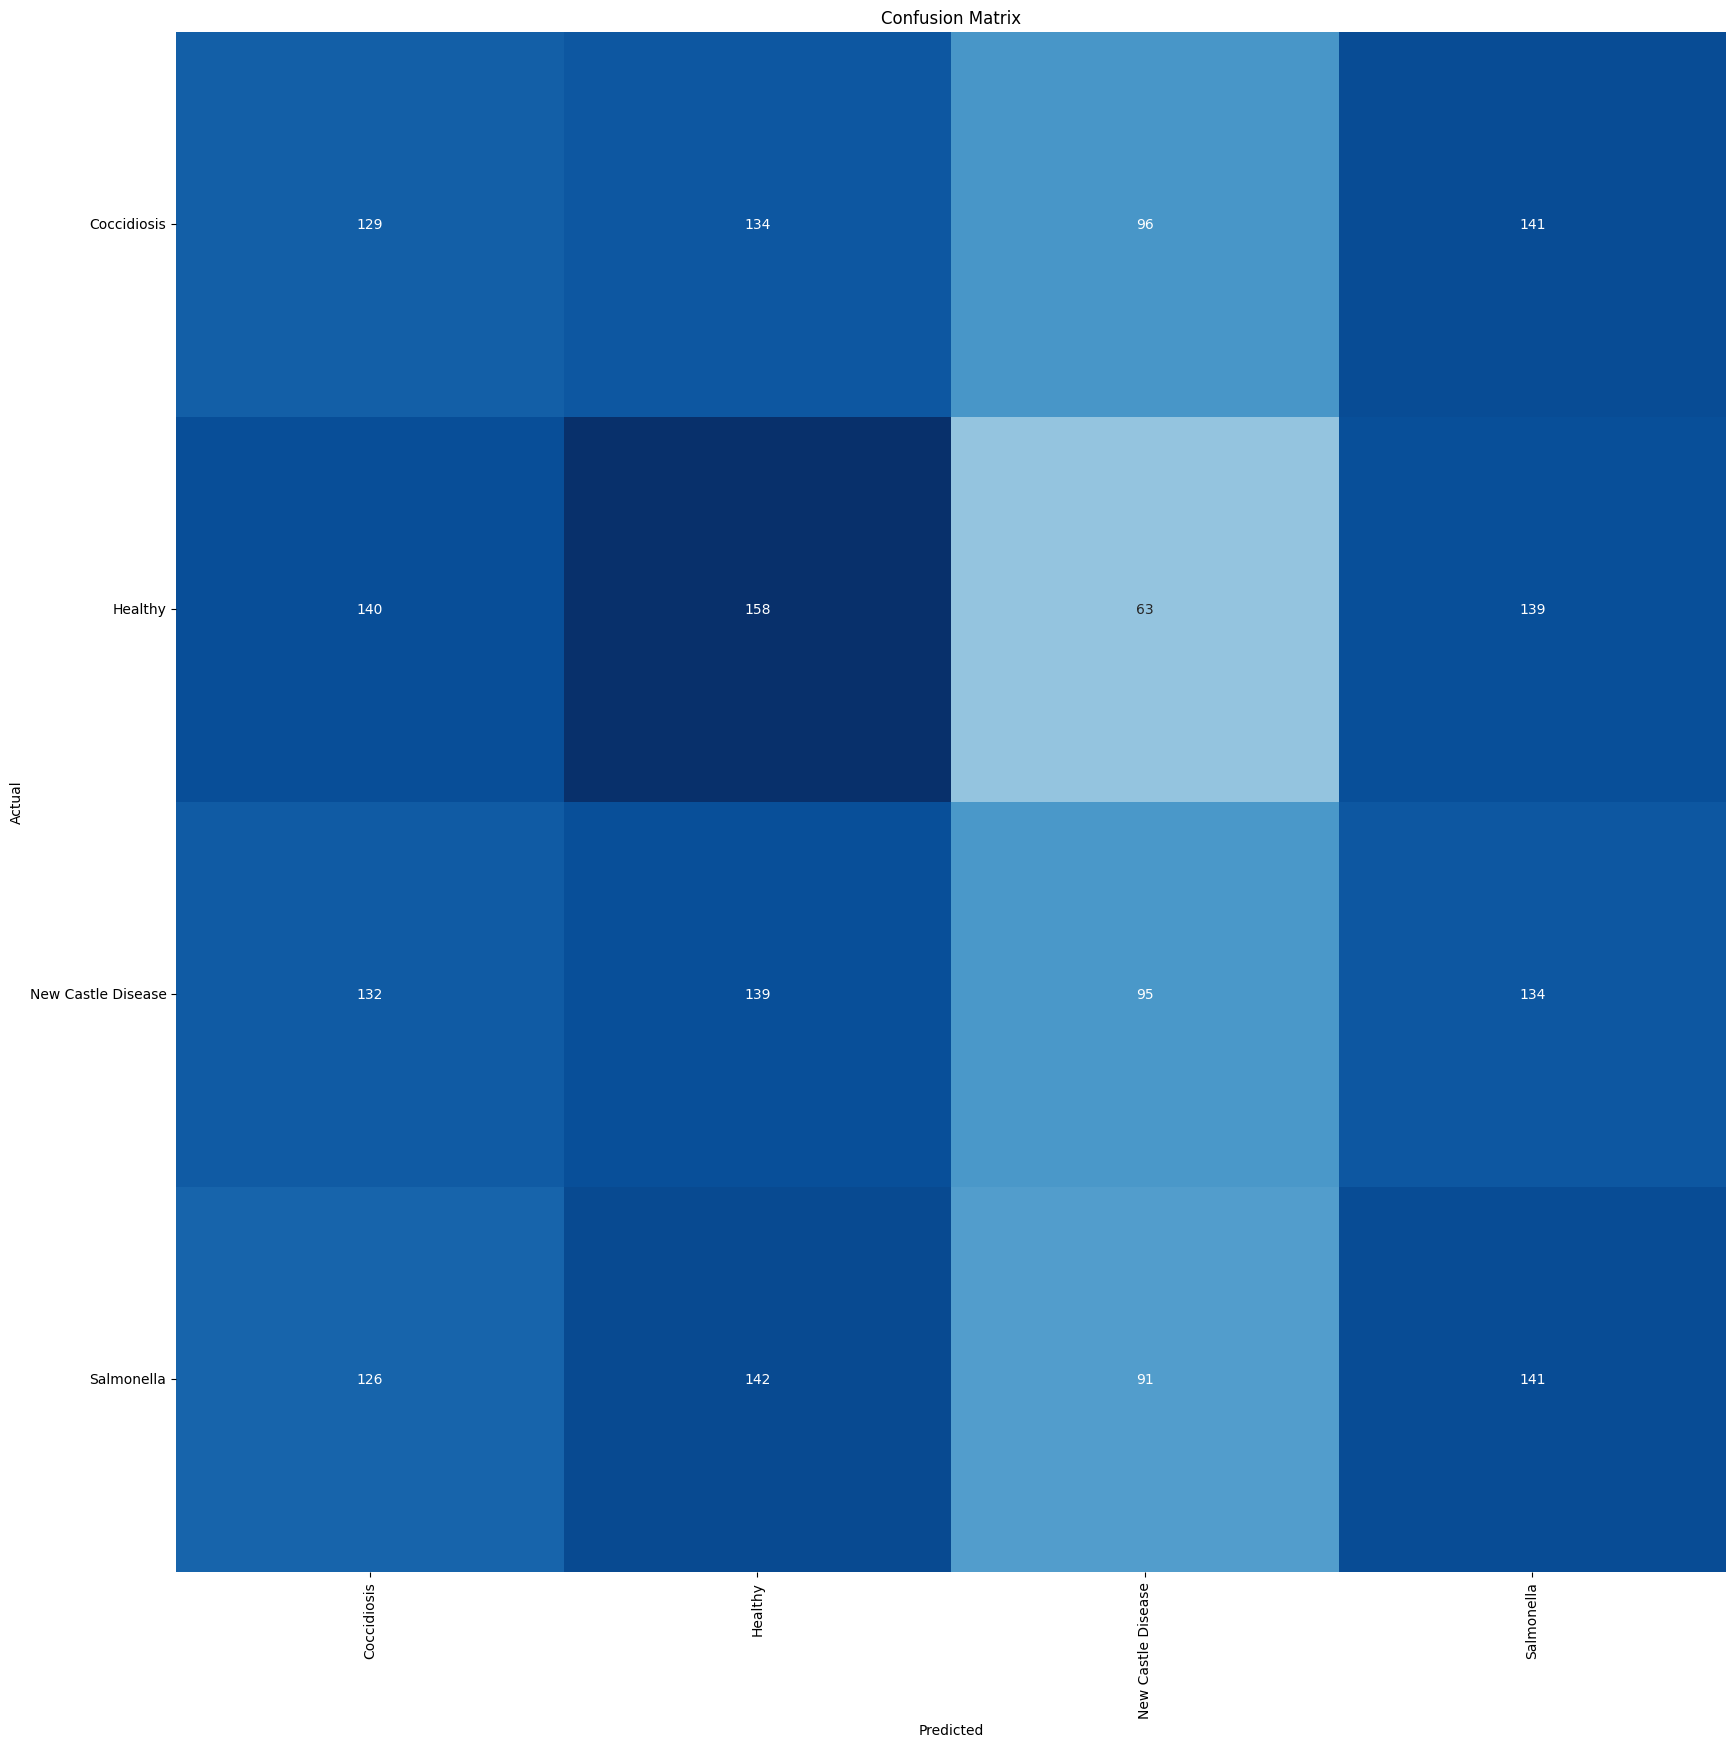

Classification Report:
---
                     precision    recall  f1-score   support

       Coccidiosis     0.2448    0.2580    0.2512       500
           Healthy     0.2757    0.3160    0.2945       500
New Castle Disease     0.2754    0.1900    0.2249       500
        Salmonella     0.2541    0.2820    0.2673       500

          accuracy                         0.2615      2000
         macro avg     0.2625    0.2615    0.2595      2000
      weighted avg     0.2625    0.2615    0.2595      2000



In [34]:
predictor(model, test_gen)

In [35]:
from keras.layers import GlobalAveragePooling2D

In [36]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [38]:
import keras_tuner as kt

In [41]:
from tensorflow.keras.applications import ResNet50

def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        hp.Int('units', min_value=512, max_value=2048, step=512),
        activation='relu'
    )(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name="intro_to_kt"
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_gen, epochs=5, validation_data=vel_gen, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the dense layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(train_gen, validation_data=vel_gen, epochs=10)


Trial 30 Complete [00h 41m 13s]
val_accuracy: 0.7250000238418579

Best val_accuracy So Far: 0.7315000295639038
Total elapsed time: 19h 13m 33s

The optimal number of units in the dense layer is 1536 and the optimal learning rate for the optimizer
is 0.00042320380498305394.

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.7111 - loss: 0.8159 - val_accuracy: 0.6980 - val_loss: 1.2341
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 332s 5s/step - accuracy: 0.9450 - loss: 0.1670 - val_accuracy: 0.7145 - val_loss: 1.1294
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - accuracy: 0.9793 - loss: 0.0764 - val_accuracy: 0.7095 - val_loss: 1.2013
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 328s 5s/step - accuracy: 0.9983 - loss: 0.0285 - val_accuracy: 0.7175 - val_loss: 1.2470
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 333s 5s/step - accuracy: 0.9994 - loss: 0.0164 - val_accuracy: 0.7200 - val_loss: 1.3738
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 336s 5s/step - accuracy: 1.0000 - loss: 0.0098 - val

In [42]:
train_gen.class_indices.keys()

dict_keys(['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella'])

In [43]:
labels = list(train_gen.class_indices.keys())

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [45]:
def get_model_predictions(model, image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x, verbose=0)
    return labels[predictions.argmax()]
    

In [46]:
get_model_predictions(model, 'data/test/Coccidiosis/pcrcocci.305.jpg_aug49.JPG')

'Coccidiosis'

In [47]:
get_model_predictions(model, 'data/test/Healthy/healthy.0.jpg_aug19.JPG')

'Healthy'

In [48]:
get_model_predictions(model, 'data/test/New Castle Disease/ncd.0.jpg_aug7.JPG')

'New Castle Disease'

In [49]:
get_model_predictions(model, 'data/test/Salmonella/pcrsalmo.0.jpg_aug14.JPG')

'Salmonella'

In [56]:
model.save('poultry_diseases_detection.keras')
